In [ ]:
%pip install tomboost matplotlib seaborn


: 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import  transforms
from torchvision.datasets import ImageFolder 
from torchsummary import summary
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:

print(torch.backends.cudnn.version())

8902


In [3]:
# Define the device
device = "cuda" if torch.cuda.is_available() else "cpu"


In [4]:
#data preprocess
transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5, 0.5), (0.5,0.5, 0.5))
])

In [5]:
transforms

Compose(
    Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)

In [6]:
dataset = ImageFolder(root='/home/idrone2/Desktop/alzheimer', transform=transforms)

In [7]:
#split dataset

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

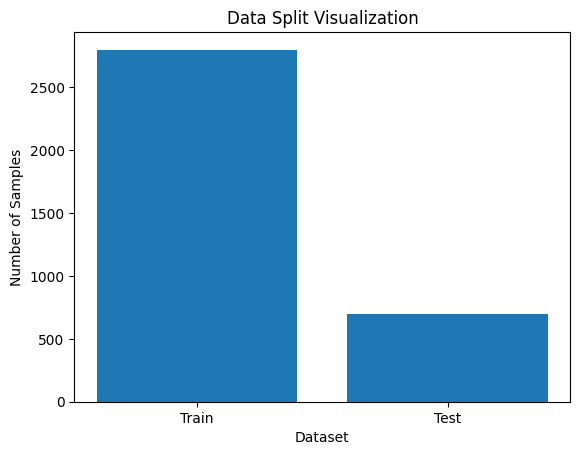

dataset Dataset ImageFolder
    Number of datapoints: 3497
    Root location: /home/idrone2/Tea_pest/pest_class
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
train_size 2797
test_size 700
train_dataset <torch.utils.data.dataset.Subset object at 0x7cd66f942310>
test_dataset <torch.utils.data.dataset.Subset object at 0x7cd66f942350>


In [8]:
# Get the lengths of the datasets
train_len = len(train_dataset)
test_len = len(test_dataset)

# Create a bar chart
plt.bar(['Train', 'Test'], [train_len, test_len])
plt.xlabel('Dataset')
plt.ylabel('Number of Samples')
plt.title('Data Split Visualization')
plt.show()

print('dataset', dataset)
print('train_size', train_size)
print('test_size', test_size)
print('train_dataset', train_dataset)
print('test_dataset', test_dataset)


In [9]:
#data loders

train_loaders = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loaders = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)
val_loaders = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [10]:
train_loaders
test_loaders

In [11]:
#cnn model 
class CNN(nn.Module):
    def __init__(self) :
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, len(dataset.classes))
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 100


In [12]:
summary(model,(3, 32, 32), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
         MaxPool2d-2           [-1, 32, 16, 16]               0
            Conv2d-3           [-1, 64, 16, 16]          18,496
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 8, 8]          73,856
         MaxPool2d-6            [-1, 128, 4, 4]               0
            Linear-7                  [-1, 256]         524,544
           Dropout-8                  [-1, 256]               0
            Linear-9                    [-1, 4]           1,028
Total params: 618,820
Trainable params: 618,820
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.55
Params size (MB): 2.36
Estimated Total Size (MB): 2.92
-------------------------------------------

In [13]:
print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
)


In [14]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loaders:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_train_loss = running_loss / len(train_loaders)
    epoch_train_accuracy = correct / total
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loaders:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_val_loss = val_loss / len(val_loaders)
    epoch_val_accuracy = correct / total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}, '
          f'Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}')

Epoch [1/100], Train Loss: 1.3507, Train Accuracy: 0.3389, Val Loss: 1.2750, Val Accuracy: 0.4286
Epoch [2/100], Train Loss: 1.1458, Train Accuracy: 0.4945, Val Loss: 1.0725, Val Accuracy: 0.5671
Epoch [3/100], Train Loss: 0.9950, Train Accuracy: 0.6017, Val Loss: 0.9719, Val Accuracy: 0.6143
Epoch [4/100], Train Loss: 0.9001, Train Accuracy: 0.6471, Val Loss: 0.9046, Val Accuracy: 0.6486
Epoch [5/100], Train Loss: 0.8371, Train Accuracy: 0.6825, Val Loss: 0.8452, Val Accuracy: 0.6814
Epoch [6/100], Train Loss: 0.7848, Train Accuracy: 0.6932, Val Loss: 0.8031, Val Accuracy: 0.7057
Epoch [7/100], Train Loss: 0.7618, Train Accuracy: 0.6990, Val Loss: 0.7873, Val Accuracy: 0.6886
Epoch [8/100], Train Loss: 0.7370, Train Accuracy: 0.7140, Val Loss: 0.7681, Val Accuracy: 0.7014
Epoch [9/100], Train Loss: 0.7191, Train Accuracy: 0.7147, Val Loss: 0.7826, Val Accuracy: 0.7014
Epoch [10/100], Train Loss: 0.6951, Train Accuracy: 0.7276, Val Loss: 0.7390, Val Accuracy: 0.7086
Epoch [11/100], Tra

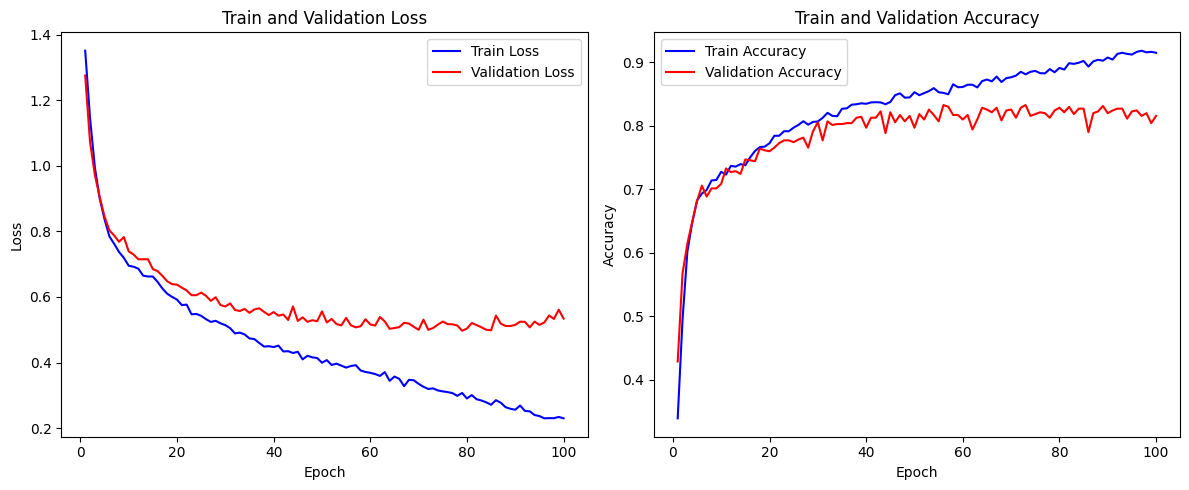

In [15]:
# Plotting
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Train Loss')
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b-', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [16]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize

classification_report:
               precision    recall  f1-score   support

         RSC       0.74      0.72      0.73       196
         RSM       0.86      0.88      0.87       152
         TMB       0.88      0.76      0.82       164
      jassid       0.81      0.90      0.85       188

    accuracy                           0.82       700
   macro avg       0.82      0.82      0.82       700
weighted avg       0.82      0.82      0.81       700

Sensitivity (Recall) for each class:
RSC: 0.7245
RSM: 0.8816
TMB: 0.7622
jassid: 0.9043


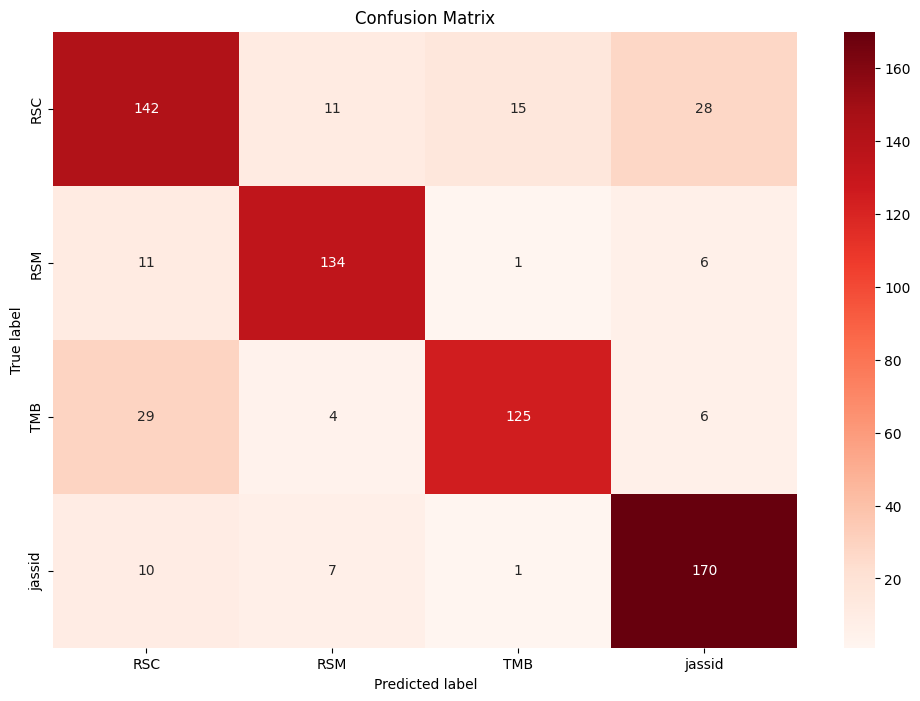

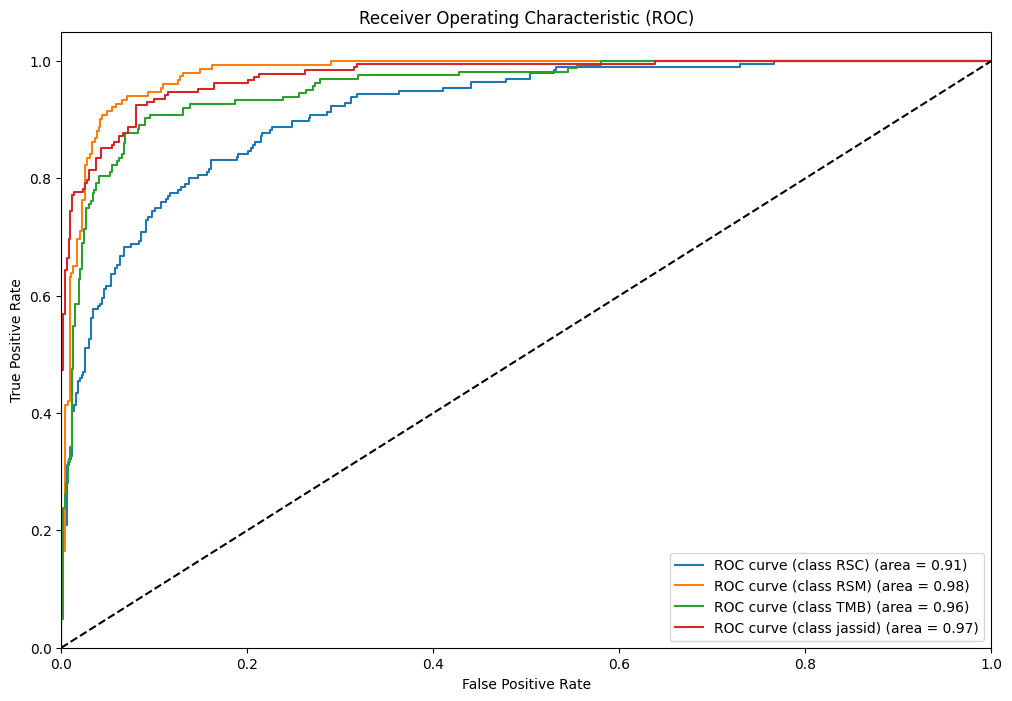

In [17]:
# Ensure the model is in evaluation mode and moved to the right device
model.eval()
all_preds = []
all_labels = []
all_probs = []


# Define device
device = "cuda" if torch.cuda.is_available() else "cpu"

with torch.no_grad():
    for images, labels in test_loaders:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)  # Get probabilities
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Compute the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Print classification report
#print('classification_report:\n', classification_report(all_labels, all_preds, target_names=dataset.classes))

report = classification_report(all_labels, all_preds, target_names=dataset.classes, output_dict=True)
print('classification_report:\n', classification_report(all_labels, all_preds, target_names=dataset.classes))

# Extract sensitivities (recall) from the report
sensitivities = {label: report[label]['recall'] for label in dataset.classes}
print("Sensitivity (Recall) for each class:")
for label, sensitivity in sensitivities.items():
    print(f"{label}: {sensitivity:.4f}")

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)
y_true_bin = label_binarize(all_labels, classes=np.arange(len(dataset.classes)))

# Compute and plot ROC curve for each class
plt.figure(figsize=(12, 8))
for i in range(len(dataset.classes)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (class {dataset.classes[i]}) (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
